In [1]:
import os
from IPython.display import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
# Load the image
image = cv2.imread("img/extracted_image_1.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_rgb); plt.axis('off'); plt.title('Original Image')
plt.subplot(1, 2, 2); plt.imshow(image_gray, cmap='gray'); plt.axis('off'); plt.title('Grayscale Image')
plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


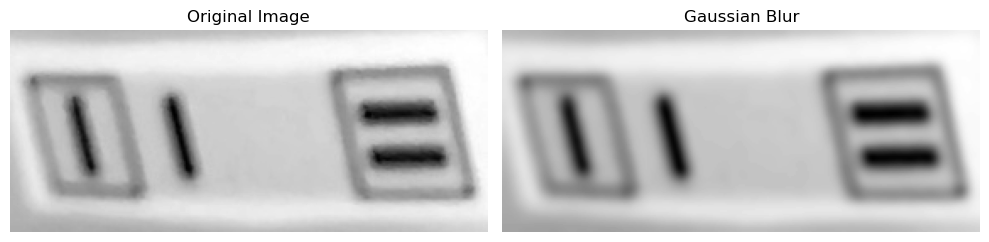

In [166]:
# Compare gaussian blur and median blur
image_blur_gaussian = cv2.GaussianBlur(image_gray, (11, 11), 0)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_gray, cmap='gray'); plt.axis('off'); plt.title('Original Image')
plt.subplot(1, 2, 2); plt.imshow(image_blur_gaussian, cmap='gray'); plt.axis('off'); plt.title('Gaussian Blur')
plt.tight_layout()
plt.show()

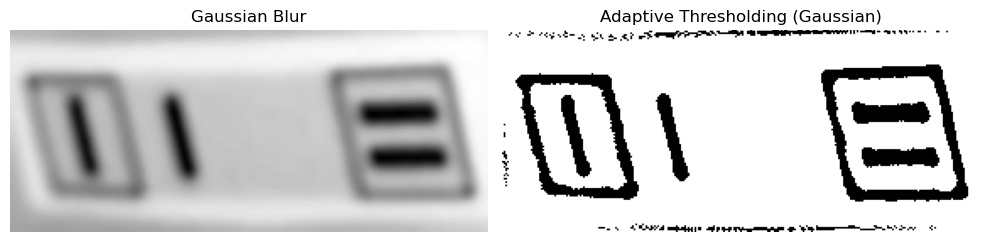

In [167]:
# Apply adaptive thresholding
threshold = 2
image_threshold_gaussian = cv2.adaptiveThreshold(image_blur_gaussian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, threshold)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_blur_gaussian, cmap='gray'); plt.axis('off'); plt.title('Gaussian Blur')
plt.subplot(1, 2, 2); plt.imshow(image_threshold_gaussian, cmap='gray'); plt.axis('off'); plt.title('Adaptive Thresholding (Gaussian)')
plt.tight_layout()
plt.show()


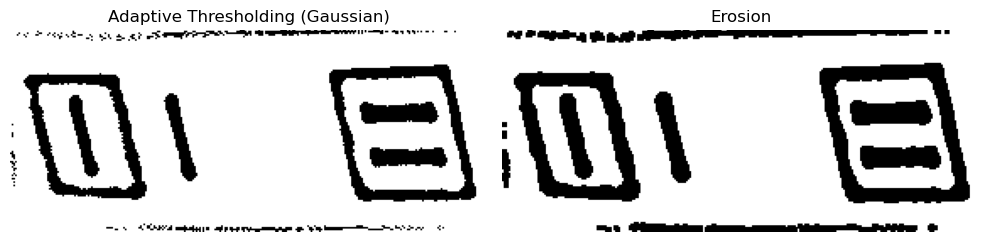

In [168]:
# To smooth the borders of the image, we can apply morphological operations such as erosion and dilation.
# Apply morphological operations
kernel = np.ones((3, 3), np.uint8)
image_erode = cv2.erode(image_threshold_gaussian, kernel, iterations=1)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_threshold_gaussian, cmap='gray'); plt.axis('off'); plt.title('Adaptive Thresholding (Gaussian)')
plt.subplot(1, 2, 2); plt.imshow(image_erode, cmap='gray'); plt.axis('off'); plt.title('Erosion')
plt.tight_layout()
plt.show()

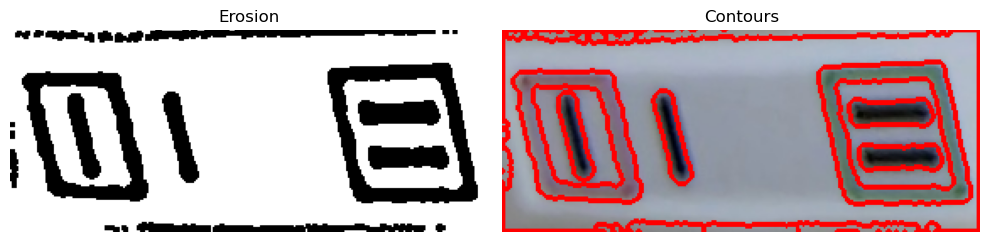

In [169]:
# Get the contours of the image
contours, _ = cv2.findContours(image_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Draw the contours on the image
image_contours = np.copy(image)
for contour in contours:
    cv2.drawContours(image_contours, contour, -1, (255, 0, 0), 2)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_erode, cmap='gray'); plt.axis('off'); plt.title('Erosion')
plt.subplot(1, 2, 2); plt.imshow(image_contours); plt.axis('off'); plt.title('Contours')
plt.tight_layout()
plt.show()

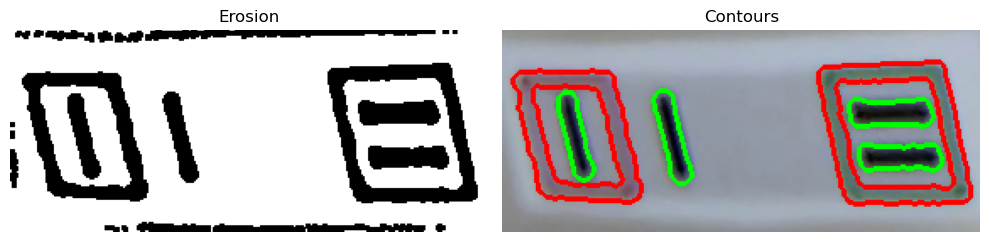

In [170]:
# Function to filter contours by size and aspect ratio
def filter_contours(contours, min_size, max_size):
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_size <= area <= max_size:
            filtered_contours.append(contour)
    return filtered_contours

# Get square contours
all_contours = filter_contours(contours, 200, 25000)

# Get square and rectangular contours
def segment_contours(contours):
    square_contours = []
    rectangular_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 0.7 <= aspect_ratio <= 1.3:
            square_contours.append(contour)
        else:
            rectangular_contours.append(contour)
    return square_contours, rectangular_contours

# Segment the contours
square_contours, rectangular_contours = segment_contours(all_contours)

# Draw the contours on the image
image_contours_filter = np.copy(image)
for contour in square_contours:
    cv2.drawContours(image_contours_filter, contour, -1, (255, 0, 0), 2)
for contour in rectangular_contours:
    cv2.drawContours(image_contours_filter, contour, -1, (0, 255, 0), 2)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_erode, cmap='gray'); plt.axis('off'); plt.title('Erosion')
plt.subplot(1, 2, 2); plt.imshow(image_contours_filter); plt.axis('off'); plt.title('Contours')
plt.tight_layout()
plt.show()